A single layer convolutional neural network with a sigmoid output, implemented with pytorch. Similar to the FVSBN, a mask is used to maintain the autoregressive property.

In [1]:
import numpy as np
import torch as tch
import math as m
import matplotlib.pyplot as plt

device = "cuda" if tch.cuda.is_available() else "cpu"
print("pytorch is running on " + device)

tr = np.load("train.npy")
va = np.load("valid.npy")
te = np.load("test.npy")

pytorch is running on cuda


In [2]:
# Single convolutional layer with sigmoid outputs.
# This is a modification of my belief net code. Some duplication could have been avoided using a superclass.
class ConvSigModel(tch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        if kernel_size % 2 != 1:
            raise RuntimeError("Kernel size must be odd.")
        self.conv = tch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size, padding='same')
        self.stack = tch.nn.Sequential(self.conv, tch.nn.Sigmoid())
        half = kernel_size // 2
        # Mask out all entries that will be after the current one as the kernel is scanned across the input
        self.mask = tch.concat((tch.ones((half, kernel_size)),
                                tch.hstack((tch.ones((1, half)), tch.zeros((1, 1 + half)))),
                                tch.zeros((half, kernel_size))))
        self.mask = self.mask.reshape((1, 1, kernel_size, kernel_size))
        self.flatten = tch.nn.Flatten()

    def forward(self, x):
        return self.stack(x + 1.) # zero is value outside the image

    # for projected SGD
    def apply_projection(self):
        self.conv.weight.data *= self.mask

    # override that moves mask array along with everything else
    def to(self, device):
        self.mask = self.mask.to(device)
        return super().to(device)

# Train model, using validation set for early stopping
def train(model : ConvSigModel, device, dl : tch.utils.data.DataLoader, validation_set = None, max_epochs = 100):
    optimizer = tch.optim.Adam(model.parameters())
    model.train() # put in training mode
    prev_loss = tch.inf
    for e in range(max_epochs):
        for batch_num, batch in enumerate(dl):
            x = batch[0].to(device) 
            optimizer.zero_grad()
            lo = log_likelihood(model, x)
            lo.backward()
            optimizer.step()
            model.apply_projection()
        if validation_set is not None:    
            va_loss = log_likelihood(model, validation_set)
            if m.isclose(prev_loss, va_loss, rel_tol=0.0001):
                print("Exiting early at epoch " + str(e))
                break
            prev_loss = va_loss
    return model

# Generate a sample from the model.
# Note that the output does not have to be the same size as the training data.
def sample(model : ConvSigModel, samp_size):
    model.eval() # put in eval mode
    device = model.conv.weight.device
    rands = tch.rand((samp_size, samp_size), device=device)
    kernel_width = model.conv.kernel_size[0]
    half = kernel_width // 2
    output = tch.zeros((1, 1, samp_size, samp_size), device=device)
    for i in range(samp_size):
        for j in range(samp_size):
            prob = model(output)[0, 0, i, j]
            output[0, 0, i, j] = 0. if rands[i, j] > prob else 1.
    return output

def log_likelihood(model : ConvSigModel, data):
    y = model(data)
    return -tch.sum(tch.log(tch.where(data != 0, y, 1 - y))) / len(data)

In [3]:
ttr = tch.from_numpy(np.asarray(tr, dtype=np.float32))
ds = tch.utils.data.TensorDataset(ttr)
dl = tch.utils.data.DataLoader(ds, batch_size=1000, shuffle=True)
tva = tch.from_numpy(np.asarray(va, dtype=np.float32))
tva = tva.to(device)

kernel_width = 11
half = kernel_width // 2
sq_tr = np.reshape(np.asarray(tr, dtype=np.float32), (len(tr), 1, 28, 28))
special = np.max(sq_tr) + 1 # special value not appearing elsewhere in data
sq_ttr = tch.from_numpy(sq_tr)
sq_ds = tch.utils.data.TensorDataset(sq_ttr)
sq_dl = tch.utils.data.DataLoader(sq_ds, batch_size=1000, shuffle=True)
sq_va = np.reshape(np.asarray(va, dtype=np.float32), (len(va), 1, 28, 28))
t_sq_va = tch.from_numpy(sq_va).to(device)
sq_te = np.reshape(np.asarray(te, dtype=np.float32), (len(te), 1, 28, 28))
t_sq_te = tch.from_numpy(sq_te).to(device)

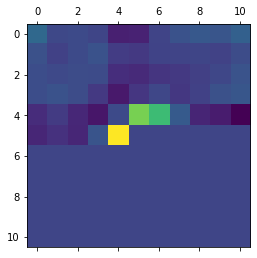

In [4]:
conv_sig_model = ConvSigModel(kernel_size=kernel_width).to(device)
conv_sig_model = train(conv_sig_model, device, sq_dl, t_sq_va)
plt.matshow(tch.squeeze(conv_sig_model.conv.weight.detach().cpu(), dim=(0,1)))

Test set log likelihood.

In [5]:
tte = tch.from_numpy(np.asarray(te, dtype=np.float32)).to(device)
log_likelihood(conv_sig_model, t_sq_te)

tensor(182.3012, device='cuda:0', grad_fn=<DivBackward0>)

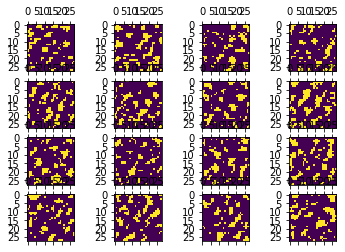

In [6]:
fig, axs = plt.subplots(4, 4)
for i in range(16):
    axs[i // 4, i % 4].matshow(np.reshape(sample(conv_sig_model, 28).cpu(), (28, 28)))